# Part 4, Topic 3: ChipWhisperer Analyzer CPA Attack (MAIN)


---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *Last time, we saw how correlation can be used to recover an AES key, as well as the effectiveness of such an attack. In this lab, we'll repeat the attack with ChipWhisperer Analyzer and gain some additional information about the attack*

**LEARNING OUTCOMES:**

* Use ChipWhisperer Analyzer to perform a CPA attack
* Plot additional information about the attack

## Prerequisites

Hold up! Before you continue, check you've done the following tutorials:

* ☑ CPA on Firmware Implementation of AES (you should understand how a CPA attack works).
* ☑ SCA101 Intro (you should have an idea of how to get hardware-specific versions running).

## Projects

There's no need for any models or SBox implementaions, or anything like that this time. Instead, everything's contained in ChipWhisperer Analyzer. Another change from previous tutorials is that we're using ChipWhisperer projects instead of numpy arrays, since most of ChipWhisperer Analyzer only works with ChipWhisperer projects.

As usual, see the associated notebook for details of the trace capture (or existing project) and copy below:

In [194]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWHUSKY'
CRYPTO_TARGET='TINYAES128C' 
SS_VER='SS_VER_2_1'

In [195]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍
scope.gain.gain                          changed from 0                         to 22                       
scope.gain.db                            changed from 15.0                      to 25.091743119266056       
scope.adc.samples                        changed from 131124                    to 5000                     
scope.clock.clkgen_freq                  changed from 0                         to 7363636.363636363        
scope.clock.adc_freq                     changed from 0                         to 29454545.454545453       
scope.clock.adc_rate                     changed from 0.0                       to 29454545.454545453       
scope.io.tio1                            changed from serial_tx                 to serial_rx                
scope.io.tio2                            changed from serial_rx                 to serial_tx                
scope.io.hs2                             changed from None                      to clkgen            

In [196]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../../firmware/mcu/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3 -j

Building for platform CWHUSKY with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
Blank crypto options, building for AES128
arm-none-eabi-gcc (GNU Arm Embedded Toolchain 10.3-2021.10) 10.3.1 20210824 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWHUSKY 
.
Welcome to another exciting ChipWhisperer target build!!
.
.
.
.
.
Compiling:
Compiling:
Compiling:
Compiling:
-en     .././simpleserial/simpleserial.c ...
-en     .././hal/hal.c ...
Compiling:
-en     .././hal//sam4s/sam4s_hal.c ...
-en     simpleserial-aes.c ...
-en     .././hal//sam4s/startup_sam4s.c ...
.
.
.
Compiling:
.
Compiling:
Compiling:
-en     .././hal//sam4s/uart.c ...
Compiling:
-en     .././hal//sam4s/pio.c ...
-en     .././hal//sam4s/system_sam4s.c ...
-en     .././hal//sam4s/sysclk.c ...
.
.
Compiling:
Compili

In [197]:
cw.program_target(scope, prog, "../../../firmware/mcu/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

In [198]:
proj = cw.create_project("Lab 4_3", overwrite=True)

In [203]:
from tqdm.notebook import trange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

N = 50
for i in trange(N, desc='Capturing traces'):
    key, text = ktp.next()
    trace = cw.capture_trace(scope, target, text, key)
    if not trace:
        continue
    
    proj.traces.append(trace)

Capturing traces:   0%|          | 0/50 [00:00<?, ?it/s]

In [204]:
scope.errors

sam_errors      = False
sam_led_setting = Default
XADC errors     = False
ADC errors      = False
extclk error    = False
trace errors    = False

In [201]:
scope.errors.clear()

In [202]:
scope.gain.db = 24

In [205]:
scope.dis()
target.dis()

Before we continue on with our CPA attack, let's take a quick look at the projects:

In [206]:
# we can access wave, textin, etc as a whole with proj.traces
for trace in proj.traces:
    print(trace.wave[0], trace.textin, trace.textout, trace.key)

# can also access individually with proj.waves, proj.textins, etc.
for wave in proj.waves:
    print(wave[0])

-0.3046875 CWbytearray(b'94 3d 46 1f 84 19 36 1a 72 72 da 50 69 43 7f 74') CWbytearray(b'98 93 49 49 da 7c 31 f9 f6 51 6c 95 46 0f 66 85') CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
-0.307861328125 CWbytearray(b'ef 02 bb 66 96 b5 8b 82 6a 86 e7 bb 59 30 2c c1') CWbytearray(b'ee 3c d9 ae 35 48 7c 6b 33 c3 57 2f 93 a0 1c c4') CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
-0.31494140625 CWbytearray(b'28 70 6c a7 56 4b 44 31 df 57 03 fa 79 2b 77 d3') CWbytearray(b'f5 4b c3 68 51 76 0e ea c1 fc 21 41 a4 7d 82 ca') CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
-0.30859375 CWbytearray(b'10 e1 6b be 5a 15 9a 2f 67 2e 17 62 33 8b 00 0d') CWbytearray(b'07 77 8a 2f bc df 01 0b 96 67 d1 08 6a 8e 63 54') CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
-0.29248046875 CWbytearray(b'8f cb f2 4b 17 3e e0 32 2f 95 e1 c6 1b 53 85 b4') CWbytearray(b'4b b6 fc 14 4f 5b 7b 2d 83 b2 2e e8 f6 a5 a1 47') CWbytearray(b'2b 7e 15 16 28 ae d2 

## ChipWhisperer Analyzer

We can access Analyzer via `chipwhisperer.analyzer`:

In [207]:
import chipwhisperer.analyzer as cwa

We also have to set our leakage model to be the SBox output. ChipWhisperer Analyzer includes a bunch of different leakage models which are useful in different situations. We'll look more at that in SCA201.

In [208]:
leak_model = cwa.leakage_models.sbox_output

The rest of the setup only takes 1 line:

In [209]:
attack = cwa.cpa(proj, leak_model)

If you want to see the attack settings, you can print the cpa object:

In [210]:
print(attack)

project     = <chipwhisperer.common.api.ProjectFormat.Project object at 0x13a025450>
leak_model  = <chipwhisperer.analyzer.attacks.models.AES128_8bit.AES128_8bit object at 0x13b125450>
algorithm   = <chipwhisperer.analyzer.attacks.cpa_algorithms.progressive.CPAProgressive object at 0x13aed5910>
trace_range = [0, 100]
point_range = [0, 5000]
subkey_list = range(0, 16)



Running the attack is also done in a single line:

In [211]:
results = attack.run()

Let's see if we got the AES key:

In [212]:
print(results)

Subkey KGuess Correlation
  00    0x2B    0.76555
  01    0x7E    0.81099
  02    0x15    0.72487
  03    0x16    0.71138
  04    0x28    0.79462
  05    0xAE    0.70024
  06    0xD2    0.75503
  07    0xA6    0.74261
  08    0xAB    0.71314
  09    0xF7    0.71094
  10    0x15    0.60045
  11    0x88    0.75794
  12    0x09    0.78559
  13    0xCF    0.71893
  14    0x4F    0.73619
  15    0x3C    0.73792



We can get the full information from the attack by calling `results.find_maximums()`, which returns:

```Python
find_maxiums() ->
    [subkey0_data, subkey1_data, subkey2_data, ...]
    
subkey0_data ->
    [guess0, guess1, guess2, ...]
    
guess0 ->
    (key_guess, location_of_max, correlation)
```

For example, if you want to print the correlation of the third best guess of the 4th subkey, you would run:

```python
print(attack_results.find_maximums()[4][3][2])
```

Note the "point location of the max" is normally not calculated/tracked, and thus returns as a 0. Using the pandas library lets us print them nicely in a DataFrame. We have to transpose the frame to get our expected orientation:

In [213]:
import pandas as pd
stat_data = results.find_maximums()
df = pd.DataFrame(stat_data).transpose()
print(df.head())

                                0                                1   \
0   [43, 1948, 0.7655454326381663]   [126, 2144, 0.810991734122269]   
1  [198, 629, 0.48041674499441356]  [51, 3437, 0.45653850192506845]   
2   [125, 225, 0.4502063816896017]  [74, 2827, 0.45535294491044803]   
3  [63, 1324, 0.44540681752765854]     [9, 2198, 0.453091699651437]   
4   [68, 2225, 0.4431822101227979]   [77, 4217, 0.4487493579095644]   

                                 2                                 3   \
0    [21, 2340, 0.7248696179774176]    [22, 2536, 0.7113763848944793]   
1  [109, 3405, 0.44822597995702773]    [23, 3693, 0.4649392573899211]   
2   [157, 3136, 0.4473903925529153]   [175, 2569, 0.4487400676813651]   
3   [133, 4838, 0.4394676658295637]    [37, 1365, 0.4235575652430881]   
4  [155, 2986, 0.43109120255402233]  [117, 2389, 0.42321048069671546]   

                               4                                 5   \
0  [40, 1992, 0.7946230431800212]   [174, 2188, 0.7002376558906

Even better, we can use the `.style` method to customize this further. This also lets us chain formatting functions. For example, we can remove the extra 0 and clean up the data. Since we know the correct key, we can even do things like printing the key in a different colour! 

You can do lots of formatting thanks to the pandas library! Check out https://pandas.pydata.org/pandas-docs/stable/style.html for more details.

In [214]:
key = proj.keys[0]
def format_stat(stat):
    return str("0x{:02X}<br>{:.3f}".format(stat[0], stat[2]))

def color_corr_key(row):
    global key
    ret = [""] * 16
    for i,bnum in enumerate(row):
        
        if bnum[0] == key[i]:
            ret[i] = "color: red"
        else:
            ret[i] = ""
    return ret

df.head().style.format(format_stat).apply(color_corr_key, axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0x2B0.766,0x7E0.811,0x150.725,0x160.711,0x280.795,0xAE0.700,0xD20.755,0xA60.743,0xAB0.713,0xF70.711,0x150.600,0x880.758,0x090.786,0xCF0.719,0x4F0.736,0x3C0.738
1,0xC60.480,0x330.457,0x6D0.448,0x170.465,0x0F0.482,0x330.470,0x070.513,0x850.518,0x7B0.489,0x6B0.479,0xC70.453,0xED0.544,0xAA0.477,0xB80.477,0x960.442,0x190.473
2,0x7D0.450,0x4A0.455,0x9D0.447,0xAF0.449,0x070.439,0x260.448,0xBD0.490,0x750.505,0xB20.473,0x590.461,0x900.449,0x1B0.453,0x890.448,0xAD0.464,0xE30.439,0xA00.454
3,0x3F0.445,0x090.453,0x850.439,0x250.424,0x890.435,0x620.437,0x690.452,0x7A0.457,0x690.448,0x060.458,0x170.443,0x7E0.440,0x5C0.442,0xFC0.451,0x780.432,0xAE0.450
4,0x440.443,0x4D0.449,0x9B0.431,0x750.423,0x060.432,0xCA0.436,0xCC0.448,0x230.450,0x590.446,0x4C0.456,0xA30.438,0x6A0.436,0xCA0.438,0xCA0.451,0x270.427,0x120.441


You should see red numbers printed at the top of a table. Congratulations, you've now completed a successful CPA attack against AES!

Next, we'll look at how we can use some of Analyzer's other features to improve the attack process, as well as better interpret the data we have.

## Reporting Intervals

When we ran `attack.run()`, we processed all of the traces before getting any information back. ChipWhisperer Analyzer actually uses the "online" correlation calculation that we mentioned last time, meaning we can get feedback during the attack. This can be done by creating a callback function and passing it to `attack.run()`. This function is called each time we pass the update interval (default 25, which is the second parameter for `attack.run()`).

Let's use this to update our table every 10 traces. Most of this is just putting our existing code into the callback function. We also need use the `clear_output` function to clear the table, as well as `display()` to actually get it to show up:

In [215]:
from IPython.display import clear_output
import numpy as np
        
def stats_callback():
    results = attack.results
    results.set_known_key(key)
    stat_data = results.find_maximums()
    df = pd.DataFrame(stat_data).transpose()
    clear_output(wait=True)
    display(df.head().style.format(format_stat).apply(color_corr_key,axis=1))
    
results = attack.run(stats_callback, 10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0x2B0.766,0x7E0.811,0x150.725,0x160.711,0x280.795,0xAE0.700,0xD20.755,0xA60.743,0xAB0.713,0xF70.711,0x150.600,0x880.758,0x090.786,0xCF0.719,0x4F0.736,0x3C0.738
1,0xC60.480,0x330.457,0x6D0.448,0x170.465,0x0F0.482,0x330.470,0x070.513,0x850.518,0x7B0.489,0x6B0.479,0xC70.453,0xED0.544,0xAA0.477,0xB80.477,0x960.442,0x190.473
2,0x7D0.450,0x4A0.455,0x9D0.447,0xAF0.449,0x070.439,0x260.448,0xBD0.490,0x750.505,0xB20.473,0x590.461,0x900.449,0x1B0.453,0x890.448,0xAD0.464,0xE30.439,0xA00.454
3,0x3F0.445,0x090.453,0x850.439,0x250.424,0x890.435,0x620.437,0x690.452,0x7A0.457,0x690.448,0x060.458,0x170.443,0x7E0.440,0x5C0.442,0xFC0.451,0x780.432,0xAE0.450
4,0x440.443,0x4D0.449,0x9B0.431,0x750.423,0x060.432,0xCA0.436,0xCC0.448,0x230.450,0x590.446,0x4C0.456,0xA30.438,0x6A0.436,0xCA0.438,0xCA0.451,0x270.427,0x120.441


A default jupyter callback is also available - the following **three lines** are all you need to run an attack!

In [216]:
import chipwhisperer as cw

cb = cwa.get_jupyter_callback(attack)
results = attack.run(cb, 10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
PGE=,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,2B0.766,7E0.811,150.725,160.711,280.795,AE0.700,D20.755,A60.743,AB0.713,F70.711,150.600,880.758,090.786,CF0.719,4F0.736,3C0.738
1,C60.480,330.457,6D0.448,170.465,0F0.482,330.470,070.513,850.518,7B0.489,6B0.479,C70.453,ED0.544,AA0.477,B80.477,960.442,190.473
2,7D0.450,4A0.455,9D0.447,AF0.449,070.439,260.448,BD0.490,750.505,B20.473,590.461,900.449,1B0.453,890.448,AD0.464,E30.439,A00.454
3,3F0.445,090.453,850.439,250.424,890.435,620.437,690.452,7A0.457,690.448,060.458,170.443,7E0.440,5C0.442,FC0.451,780.432,AE0.450
4,440.443,4D0.449,9B0.431,750.423,060.432,CA0.436,CC0.448,230.450,590.446,4C0.456,A30.438,6A0.436,CA0.438,CA0.451,270.427,120.441


Here we used a reporting interval of 10 traces. Depending on the attack and what you want to learn from it, you may want to use higher or lower values: in general reporting less often is faster, but more frequent reporting can allow you to end a long attack early. More frequent reporting also increases the resolution of some plot data (which we will look at next).

## Plot Data

Analyzer also includes a module to create plots to help you interpret the data. These act on one subkey at a time and return some data that we can plot using bokeh (or your graphing module of choice). Let's start by grabbing the class that does all the calculations:

In [29]:
plot_data = cwa.analyzer_plots(results)

We'll start by looking at the Output Vs. Time module, which will allow us to plot correlation of our guesses in time. This is useful for finding exactly where the operations we're attacking are. Like in previous tutorials, we'll use bokeh to plot the data we get back.

The method we're interested in is `get_plot_data(bnum)`, which returns in a list: `[xrange, correct_key, incorrect_key_data, incorrect_key_data]` for the position `bnum` passed to it. The method returns two sets of incorrect key data because one is for the key guesses below the correct one, and the other is for guesses above the correct one.

We'll have a lot of points, so we'll plot as usual, but at the end decimate the output:

In [45]:
def byte_to_color(idx):
    return hv.Palette.colormaps['Category20'](idx)
    
import pandas as pd
import numpy as np

a = []
b = []
for i in range(0, 16):
    data = plot_data.output_vs_time(i)
    a.append(np.array(data[1])) # Correct key
    b.append(np.array(data[2])) # Incorrect key data
    b.append(np.array(data[3])) # Incorrect key data
    
pda = pd.DataFrame(a).transpose().rename(str, axis='columns')
pdb = pd.DataFrame(b).transpose().rename(str, axis='columns')

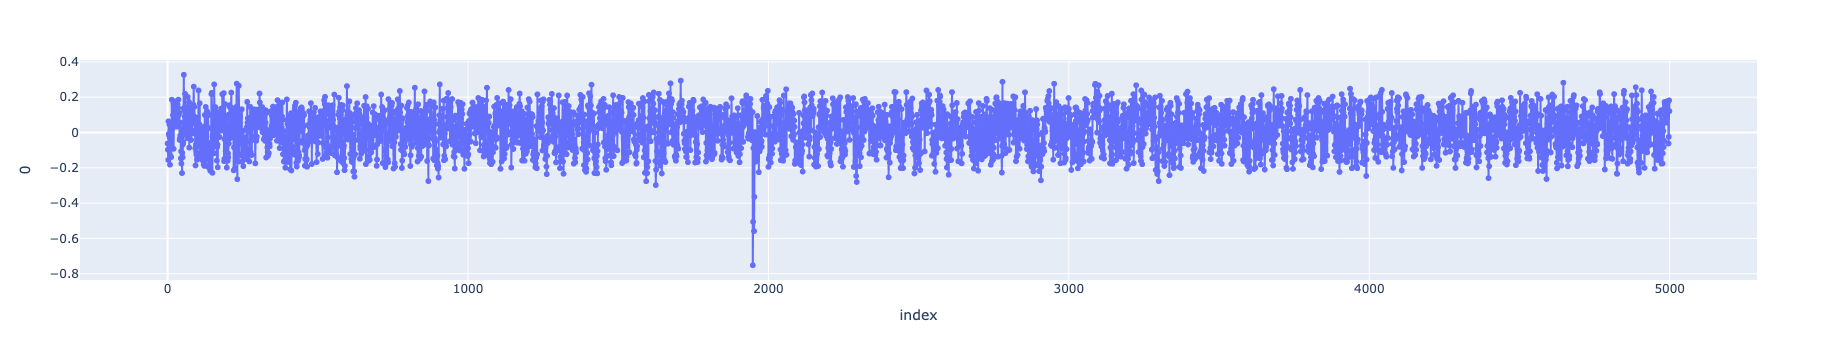

In [47]:
import plotly.express as px

fig = px.line(pda, y='0', markers=True)
fig.show()

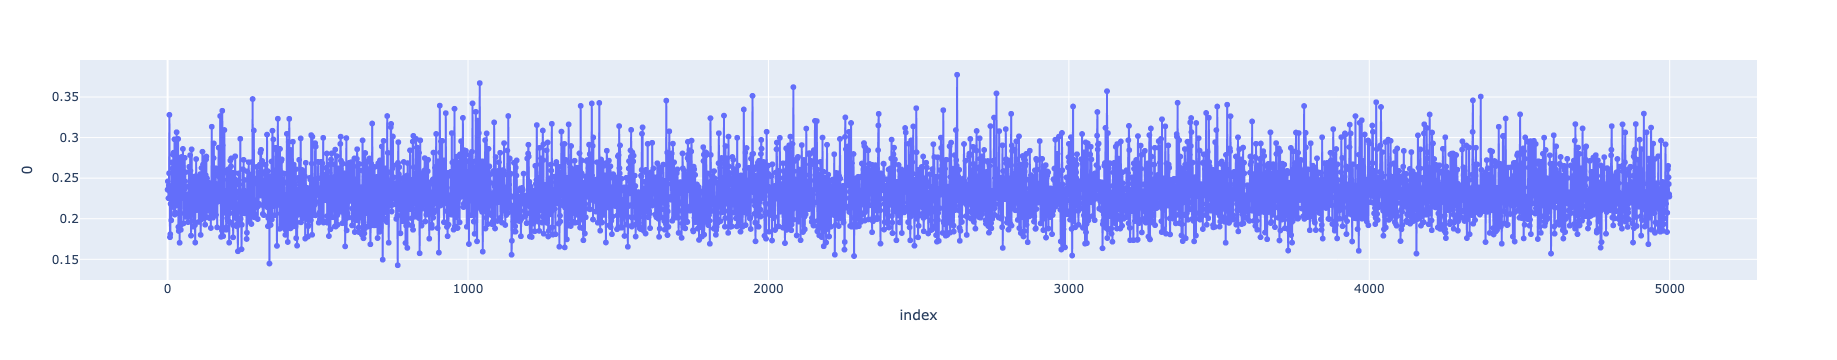

In [48]:
fig = px.line(pdb, y='0', markers=True)
fig.show()

You should see some distinctive spikes in your plot. The largest of these is where the sbox lookup is actually happening (the smaller ones are typically other AES operations that move the sbox data around). We are normally talking absolute values, so you'll see negatives in there.

This information can be useful in many ways. For example, you can probably see the first 16 spikes that make up the sbox lookup are a small portion of the total trace length. If we ever needed to rerun the attack, we could capture a much smaller number of samples and speed up analysis significantly!

### PGE vs. Traces

The next data we'll look at is a plot of partial guessing entropy (PGE) vs. the number of traces. As mentioned before, PGE is just how many spots away from the top the actual subkey is in our table of guesses. For example, if there are 7 subkey guesses that have a higher correlation than the actual subkey, the subkey has a PGE of 7.

This plot is useful for seeing how many traces were needed to actually break the AES implementation. Keep in mind, however, that the resolution of the plot is determined by the reporting interval (also note that `attack_results.find_maximums()` must be called in the callback function). In our case, we have a reporting interval of 10, so we'll have a resolution of 10 traces.

This method is similar to the previous plot in that it takes `bnum` as an argument and returns a list of `[xrange, PGE]`. 

In [99]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

byte_len = 16
cmap = plt.cm.inferno
#colors = [cmap(i / byte_len) for i in range(byte_len)]
data = {}
for i in range(byte_len):
    data[str(i)] = plot_data.pge_vs_trace(i)[1]
x_axis = plot_data.pge_vs_trace(0)[0]
#plot_y_array = [(plot_data.pge_vs_trace(i)[1], "", mcolors.to_hex(colors[i])) for i in range(byte_len)]

pge_frame = pd.DataFrame(data, index=x_axis).rename(str, axis='columns')
#pge_frame["x"] = [0.0] + plot_data.pge_vs_trace(0)[0]
#pge_frame.set_index("x")

In [100]:
pge_frame

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
10,212.0,5.0,106.0,146.0,26.0,117.0,224.0,25.0,60.0,225.0,1.0,44.0,186.0,13.0,72.0,166.0
20,0.0,42.0,134.0,2.0,0.0,252.0,21.0,2.0,4.0,5.0,5.0,3.0,44.0,0.0,32.0,0.0
30,0.0,0.0,3.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,1.0,0.0,100.0,0.0,18.0,0.0
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0.0,4.0,0.0
50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0
60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


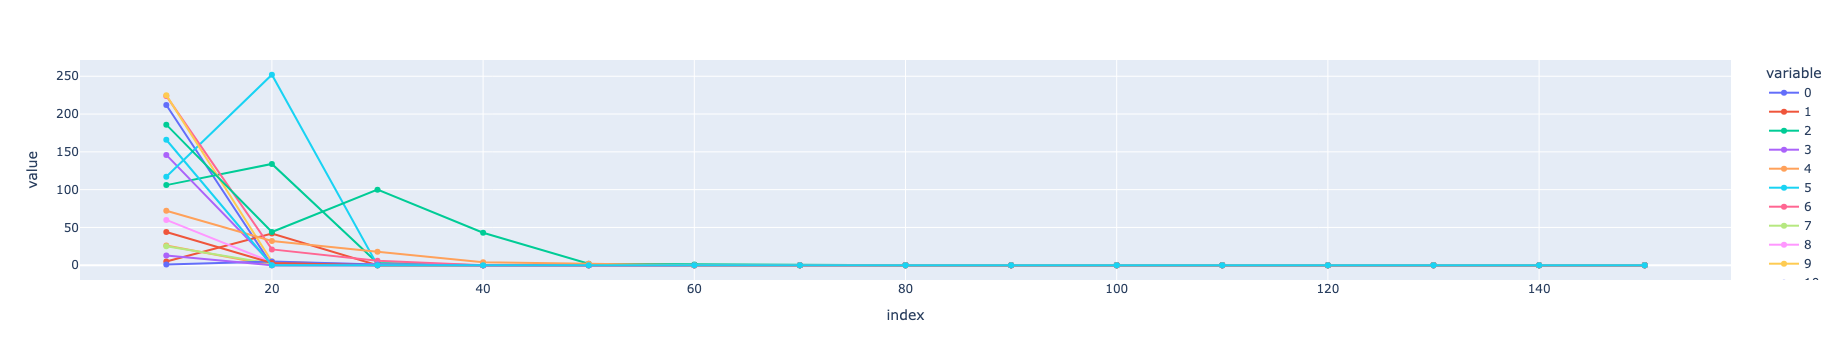

In [101]:
fig = px.line(pge_frame, markers=True)
fig.show()

You should see a number of lines that start off with high values, then rapidly drop off. You may notice that we broke the AES implementation without needing to use all of our traces. 

Even though we may have broken the AES implementation in fewer traces, we may not want to reduce how many traces we capture. Remember that, while we know the key here, for a real attack we won't and therefore must use the correlation to determine when we've broken a key. Our next plot will help us to determine how feesible capturing fewer traces is.

### Correlation vs. Traces

The last plot we'll take a look at is correlation vs the number of traces. Like with PGE vs. Traces, this plot's resolution is determined by the reporting interval (10 in our case). This method returns a list of `[xrange, [data_for_kguess]]`, so we'll need to plot each guess for each subkey. Like before, we'll do the plot for the correct subkey in a changing color and the rest in black.

As you will see, all the subkey guesses start of with large correlations, but all of them except for the correct guess quickly drop off. If you didn't know the key, at what point would you be sure that the guess with the highest correlation was actually the correct subkey?

Let's continue and plot the correlations for the right guess and the next best one:

In [158]:
import itertools

a = {}
b = {}
for bnum in range(16):
    data = plot_data.corr_vs_trace(bnum)
    best = [0]
    for i in range(256):
        if i == key[bnum]:
            a[str(bnum)] = np.array(data[1][i])
        elif max(best) < max(data[1][i]):
            best = data[1][i]
    b[str(bnum)] = np.array(best)

a['x'] = [i for i in range(15)]
b['x'] = [i for i in range(15)]
pda = pd.DataFrame(a).rename(str, axis='columns')
pdb = pd.DataFrame(b).rename(str, axis='columns')

assert pdb.columns.all() == pda.columns.all()

In [192]:
df1_long = pda.melt(id_vars='x', var_name='line', value_name='y')
df1_long['source'] = 'pda'

df2_long = pdb.melt(id_vars='x', var_name='line', value_name='y')
df2_long['source'] = 'pdb'

df1_long['label'] = 'pda_' + df1_long['line']
df2_long['label'] = 'pdb_' + df2_long['line']

df_all = pd.concat([df1_long, df2_long], ignore_index=True)

black_lines = df2_long['label'].unique()
color_map = {line: 'black' for line in black_lines}

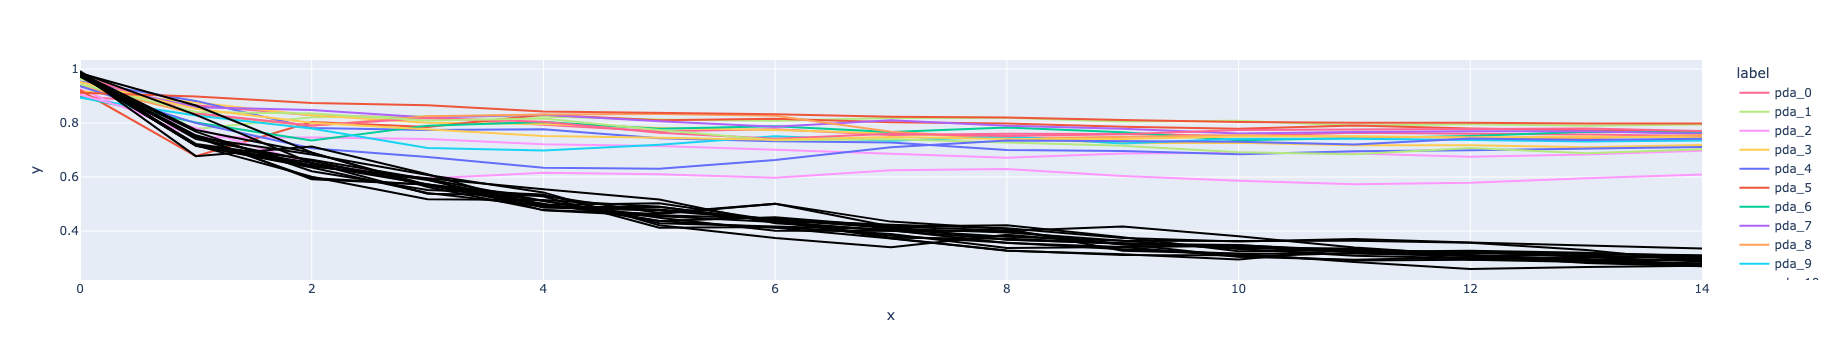

In [193]:
px.line(df_all,
        x='x',
        y='y',
        color='label',
        line_group='label',
        color_discrete_map=color_map).show()

## Conclusions & Next Steps

As you've seen, Analyzer makes launching a CPA attack much easier than our manual way. It also has the advantage of capturing some interesting data for us, and reporting the attack success every so often.

Congratulations, you've reached the end of the main part of SCA101! If you've got a ChipWhisperer-Lite or ChipWhisperer 1200 (Pro), there's a bonus lab that will showcase using a more realisitc trigger. This is also discussed in the slides and training videos.

---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>